<a href="https://colab.research.google.com/github/gregor-posadas/Gregor-Projects/blob/main/mod08_Snow17_calibration_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 08: Model Calibration – Assignment

In this assignment, you will extend the work we have done on model calibration to explore the following questions:

1. When we calibrate the model on RMSE, how sensitive are our optimized parameters to our initial guess? And
2. How different are the results when we calibrate the model on MAE?

To address these questions, you will calibrate the model for four sets of initial guesses that correspond effectively to the four "corners" of our feasible space of parameters `DD` and `Tt`. You will plot the resulting calibrated values of these parameters to investigate the degree to which your calibrated parameters depend on where on the RMSE objective function surface you started. Then you'll repeat the analysis, but instead of calibrating to RMSE, you'll write code to calibrate the Snow-17 model to MAE.

## 1. Notebook Setup

Below we load the libraries we will need and initialize important variables

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import numbers

# The name of file that contains forcing and observed SWE during every day of water year 2001-2020
forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

# The name of the file containing parameter combinations and associated KGE values from our
# sensitivity analysis
saved_error_metric_values_fname = 'Snow17_sensitivity_analysis.csv'

date_beg = '2000-10-01' # This is the first day of water year 2016
date_end = '2020-09-30' # This is the last day of water year 2020

DD_i = np.array([2.0, 2.0, 9.0, 9.0]) # Initial guesses for degree-day factor
Tt_i = np.array([0.0, 6.0, 6.0, 0.0]) # Initial guesses for temperature threshold


## 2. Load the Forcing Data

This data corresponds to the same East River watershed data we have been using throughout this module.

In [28]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

ForcingDates = df_forcing[date_beg:date_end]['Date'].values
P_exp = df_forcing[date_beg:date_end]['pcp'].values
Ta_exp = df_forcing[date_beg:date_end]['tair'].values
SWE_o = df_forcing[date_beg:date_end]['SWE'].values

t = pd.date_range(start=date_beg, end=date_end, freq='1D')

# Here's what a pandas "dataframe" looks like:
df_forcing

,Date,tair,pcp,Q,SWE,PET
Date,,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,NaN,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,NaN,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,NaN,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,NaN,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,NaN,3.244371
...,...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,0.0,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,0.0,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,0.0,3.412351


## 3. Define Some Critical Functions

### 3.1 Create a Function Defining the Snow-17 Model

In [29]:
def Snow17(Ta,P,DD,Tt):

    assert Ta.shape == P.shape, 'Precipitation and Temperature vectors must have the same shape'
    assert isinstance(DD, numbers.Number), 'Degree day coefficient must be a scalar'
    assert isinstance(Tt, numbers.Number), 'Temperature threshold must be a scalar'

    Nt = np.max(Ta.shape)

    SWE_s17 = np.zeros(Ta.shape)
    Sm_s17 = np.zeros(Ta.shape)
    Pliq_s17 = np.zeros(Ta.shape)

    for i in np.arange(Nt):

        P_i  = P[i] # The value of precipitation on this date
        Ta_i = Ta[i] # The value of average air temperature on this date

        # Initial conditions: we are starting when there should not be any appreciable snow in the watershed,
        # so we will assume that SWE = 0. If you decide to run another date when there might be snow (e.g., Jan. 1)
        # then you would need a more realistic value of SWE.
        if(i==0):
            SWE_i = 0.0
        else:
            SWE_i = SWE_s17[i-1] # The initial SWE on these dates is simply the SWE from the day before. We will add snow or subtract melt.

        # If SWE is greater than zero, there *may* be snowmelt
        if(SWE_i>0.0):
            if(Ta_i>Tt): # If the air temperature is greater than the threshold, there **will** be melt
                Sm_i = DD*(Ta_i-Tt) # Snowmelt via degree-day factor
            else: # If the air temperature is below the threshold, there is no melt
                Sm_i = 0.0 # No snowmelt if temperature does not exceed threshold
        else: # If there is no SWE, by definition there is no snowmelt
            Sm_i = 0.0

        # If there is precipitation, figure out its phase
        if((P_i>0.0) and (Ta_i<=Tt)):
            SWE_i += P_i # All precip will be added to SWE storage
            Pliq_i = 0.0 # There is no liquid precipitation
        elif((P_i>0.0) and (Ta_i>Tt)):
            Pliq_i = P_i # All precipitation falls as liquid. NOTE: We are assuming rain does not melt snow!!!
        else: # If there is no precipitation, there is nothing to accumulate
            Pliq_i = 0.0

        SWE_s17[i] = np.max([SWE_i - Sm_i,0.0]) # Make sure we can only melt as much SWE as there is. This only matters at low SWE
        Sm_s17[i] = Sm_i # Save the snowmelt... QUESTION: Is this something we can observe?!?!?!?!
        #Snowmelt isn’t usually observed directly, but we can infer it from changes in SWE, temperatures above freezing, or increases in streamflow during melt periods.
        Pliq_s17[i] = Pliq_i


    return SWE_s17, Sm_s17, Pliq_s17

### 3.2 Create a Function to Calculate RMSE

In [30]:
def RMSE(y_m,y_o):

    # Inputs:
    # y_m: Modeled time series
    # y_o: Observed time series

    RMSE = np.sqrt(np.nanmean((y_m - y_o)**2))

    return RMSE

### 3.3 Create an Objective Function Based on RMSE

In [31]:
def objective_function_rmse(params):
    DD_exp, Tt_exp = params # Get DD and Tt parameters

    # 1. Call Snow-17 model
    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp,P_exp,DD_exp,Tt_exp)

    # 2. Get RMSE value for simulated SWE
    RMSE_exp = RMSE(SWE_m,SWE_o)

    # 3. Return RMSE because the optimization function we're using seeks minimization
    return RMSE_exp


## 4. Calibrate on RMSE

Below, find the lines with comments labelled `TODO:` and insert/modify the code appropriately

In [32]:
N_ig = DD_i.size # The number of initial conditions being considered

# TODO: Create containers to store optimized DD and Tt
optimized_DD_rmse = np.zeros(N_ig)
optimized_Tt_rmse = np.zeros(N_ig)

for i in np.arange(N_ig):
    initial_guess = [DD_i[i], Tt_i[i]]  # Define initial guess


    # Calibrate the model based on this initial guess
    optimized_params_rmse = optimize.minimize(
        objective_function_rmse,
        initial_guess,
        method='CG',
        jac='3-point',
        options={
            'disp': True,
            'maxiter': 2000,
        }
        )

    # Print the values of the optimized parameters to the screen
    print("Optimized Parameters:", optimized_params_rmse.x)

    # TODO: Store the calibrated parameters in the array you created above
    optimized_DD_rmse[i] = optimized_params_rmse.x[0]
    optimized_Tt_rmse[i] = optimized_params_rmse.x[1]



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 60.201041
         Iterations: 0
         Function evaluations: 342
         Gradient evaluations: 66
Optimized Parameters: [2. 0.]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 32.602012
         Iterations: 9
         Function evaluations: 437
         Gradient evaluations: 85
Optimized Parameters: [7.66340649 4.28108359]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 32.602336
         Iterations: 10
         Function evaluations: 610
         Gradient evaluations: 118
Optimized Parameters: [7.6447222  4.27966492]
         Current function value: 32.602189
         Iterations: 13
         Function evaluations: 476
         Gradient evaluations: 93
Optimized Parameters: [7.69057233 4.28314745]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


### 4.1 Plot the Results

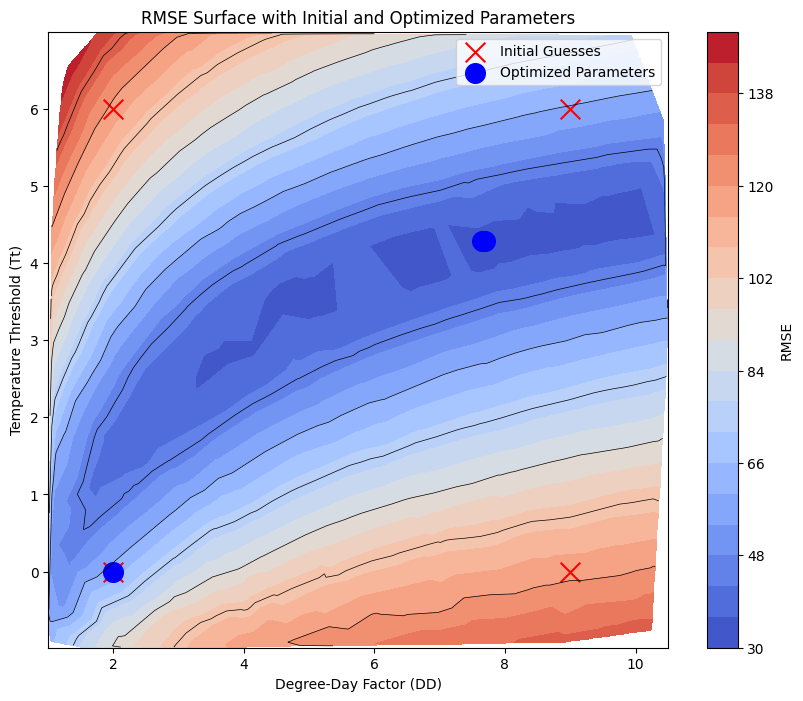

In [38]:
# TODO:
# 1. Read in the RMSE surface we created in the sensitivity analysis/brute force calibration notebook
sensitivity_df = pd.read_csv('Snow17_sensitivity_analysis.csv')
DD_vals = sensitivity_df['DD'].values
Tt_vals = sensitivity_df['Tt'].values
RMSE_vals = sensitivity_df['RMSE'].values

# 2. Use the contour() and contourf() to create a plot of the RMSE surface
# Create a meshgrid of DD and Tt values
DD_grid, Tt_grid = np.meshgrid(
    np.linspace(DD_vals.min(), DD_vals.max(), 1000),  # Generate 100 points for DD
    np.linspace(Tt_vals.min(), Tt_vals.max(), 1000)  # Generate 100 points for Tt
)

# Interpolate RMSE values to fit the grid
from scipy.interpolate import griddata
RMSE_grid = griddata(
    points=(DD_vals, Tt_vals), values=RMSE_vals,
    xi=(DD_grid, Tt_grid), method='linear'
)

plt.figure(figsize=(10, 8))  # Set figure size

# Plot the RMSE surface
plt.contourf(DD_grid, Tt_grid, RMSE_grid, levels=20, cmap='coolwarm')
plt.colorbar(label='RMSE')  # Add color bar
plt.contour(DD_grid, Tt_grid, RMSE_grid, levels=10, colors='black', linewidths=0.5)

# 3. Plot the initial guesses on the plot as large Xs
plt.scatter(DD_i, Tt_i, c='red', marker='x', s=200, label='Initial Guesses')

# 4. Plot the optimized guesses on the plot as large Os
plt.scatter(optimized_DD_rmse, optimized_Tt_rmse, c='blue', marker='o', s=200, label='Optimized Parameters')

# Add labels, title, and legend
plt.xlabel('Degree-Day Factor (DD)')
plt.ylabel('Temperature Threshold (Tt)')
plt.title('RMSE Surface with Initial and Optimized Parameters')
plt.legend(loc='upper right')  # Add legend to describe markers

# Show the plot
plt.show()


## 5. Now Calibrate to MAE

Now you will repeat the above analysis, but instead calibrate the model to the mean absolute error (MAE), an error metric we also examined in our sensitivity analysis.

### 5.1 Define a Function to Calculate MAE

In [45]:
def MAE(y_m, y_o):
    # Ensure inputs are numpy arrays
    y_m = np.array(y_m)
    y_o = np.array(y_o)

    # Compute Mean Absolute Error
    mae = np.nanmean(np.abs(y_m - y_o))
    return mae

### 5.2 Create an Objective Function Based on MAE

In [46]:
def objective_function_mae(params):
    # TODO: Get the parameters
    DD_exp, Tt_exp = params  # Extract the degree-day factor (DD) and temperature threshold (Tt)

    # TODO: Calculate SWE with input parameters
    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp, P_exp, DD_exp, Tt_exp)  # Call Snow17 model

    # TODO: Call function to calculate MAE
    MAE_exp = MAE(SWE_m, SWE_o)  # Calculate MAE between modeled SWE and observed SWE

    return MAE_exp

### 5.3 Calibrate the Model to MAE

Use the code immediately below section 4 above to calibrate the model. Use the same 4 initial guesses we defined at the top of the notebook.

In [48]:
# TODO: Insert code to call `optimize.minimize()` for each initial guess and using MAE

# Containers to store optimized parameters for MAE
optimized_DD_mae = np.zeros(N_ig)  # Store optimized DD values
optimized_Tt_mae = np.zeros(N_ig)  # Store optimized Tt values

# Loop through each initial guess
for i in np.arange(N_ig):
    initial_guess = [DD_i[i], Tt_i[i]]  # Define the initial guess
    print(f"Initial Guess {i + 1}: {initial_guess}")  # Debug: print initial guess

    # Optimize parameters to minimize MAE
    optimized_params_mae = optimize.minimize(
        objective_function_mae,
        initial_guess,
        method='CG',  # Conjugate Gradient method
        jac='3-point',  # Numerical derivative
        options={
            'disp': True,  # Display optimization info
            'maxiter': 2000,  # Maximum iterations
        }
    )

    # Print the optimized parameters
    print(f"Optimized Parameters for Guess {i + 1}: DD = {optimized_params_mae.x[0]:.2f}, Tt = {optimized_params_mae.x[1]:.2f}")

    # Store the results
    optimized_DD_mae[i] = optimized_params_mae.x[0]
    optimized_Tt_mae[i] = optimized_params_mae.x[1]


Initial Guess 1: [2.0, 0.0]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 30.488001
         Iterations: 0
         Function evaluations: 437
         Gradient evaluations: 85
Optimized Parameters for Guess 1: DD = 2.00, Tt = 0.00
Initial Guess 2: [2.0, 6.0]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 15.701677
         Iterations: 15
         Function evaluations: 674
         Gradient evaluations: 133
Optimized Parameters for Guess 2: DD = 7.73, Tt = 4.29
Initial Guess 3: [9.0, 6.0]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 16.198452
         Iterations: 2
         Function evaluations: 316
         Gradient evaluations: 63
Optimized Parameters for Guess 3: DD = 9.24, Tt = 4.47
Initial Guess 4: [9.0, 0.0]
         Current function value: 15.702013
         Iterations: 8
         Function evaluations: 360
         Gradient evaluations: 71
Optimized Parameters for Guess 4: DD = 7.70, Tt = 4.28


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


### 5.4 Plot the Results

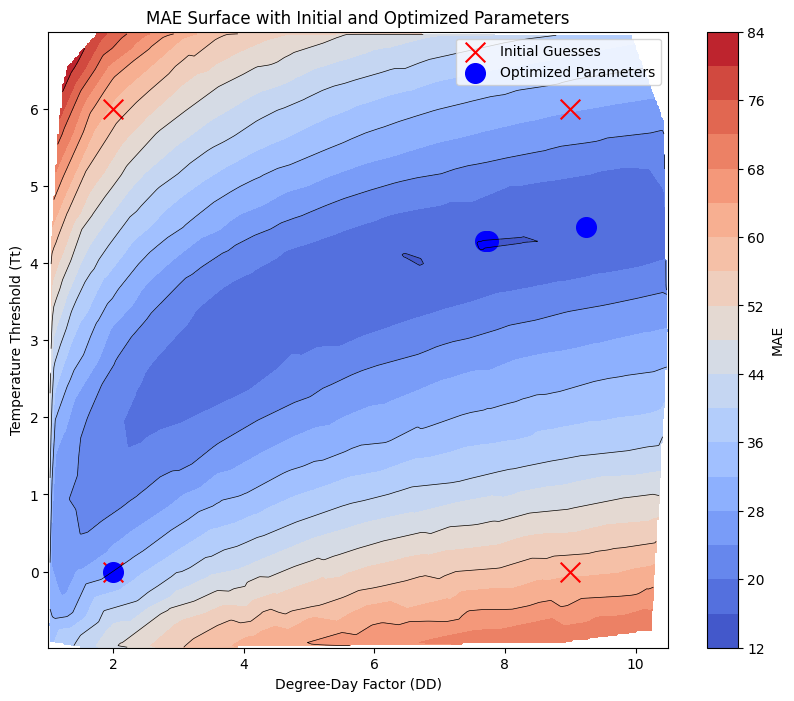

In [49]:
# TODO:
# 1. Read in the MAE surface we created in the sensitivity analysis/brute force calibration notebook
sensitivity_df = pd.read_csv('Snow17_sensitivity_analysis.csv')  # Replace with actual file name if different
DD_vals = sensitivity_df['DD'].values
Tt_vals = sensitivity_df['Tt'].values
MAE_vals = sensitivity_df['MAE'].values  # Replace with actual column name for MAE

# 2. Use the contour() and contourf() to create a plot of the MAE surface
# Create a meshgrid of DD and Tt values
unique_DD = np.unique(DD_vals)
unique_Tt = np.unique(Tt_vals)
DD_grid, Tt_grid = np.meshgrid(unique_DD, unique_Tt)

# Interpolate MAE values to fit the grid
from scipy.interpolate import griddata
MAE_grid = griddata(
    points=(DD_vals, Tt_vals), values=MAE_vals,
    xi=(DD_grid, Tt_grid), method='linear'
)

plt.figure(figsize=(10, 8))  # Set figure size

# Plot the MAE surface using filled contours
plt.contourf(DD_grid, Tt_grid, MAE_grid, levels=20, cmap='coolwarm')  # Blue-White-Red colormap
plt.colorbar(label='MAE')  # Add color bar

# Add line contours for more detail
plt.contour(DD_grid, Tt_grid, MAE_grid, levels=10, colors='black', linewidths=0.5)

# 3. Plot the initial guesses on the plot as large Xs
plt.scatter(DD_i, Tt_i, c='red', marker='x', s=200, label='Initial Guesses')

# 4. Plot the optimized guesses on the plot as large Os
plt.scatter(optimized_DD_mae, optimized_Tt_mae, c='blue', marker='o', s=200, label='Optimized Parameters')

# Add labels, title, and legend
plt.xlabel('Degree-Day Factor (DD)')
plt.ylabel('Temperature Threshold (Tt)')
plt.title('MAE Surface with Initial and Optimized Parameters')
plt.legend(loc='upper right')  # Add legend to describe markers

# Show the plot
plt.show()


## 6 Reflection Questions

Answer the following reflection questions:

1. How sensitive are the optimized parameters to the initial guess? Did calibrating to MAE result in appreciably different results when compared to calibrating to RMSE?
* *The optimized parameters were a little sensitive to the initial guess, but overall, the results still converged toward similar values, especially for MAE. Compared to RMSE, calibrating to MAE led to slightly different results since MAE focuses more on reducing average errors and isn’t as influenced by outliers. So, the difference is noticeable but not extreme.*

2. What are the implications of the above results? How would you coach a colleague who is considering creating a Snow-17 model for a different location in, for example, Washington or Idaho?
* *The main takeaway is that starting guesses matter, but the model’s calibration process is pretty robust if your initial guesses aren’t too far off. I’d suggest they focus on getting a good dataset for SWE and weather inputs because the model depends on that quality. For different locations, they’d want to tune DD and Tt based on local climate conditions (e.g., snowmelt timing, precipitation patterns).*

3. How generalizable do you think your conclusions are for __*other*__ models? Based on what we've done in this module? How might you approach calibration of a model that is of a completely different process but of similar complexity? For example, say you needed to calibrate the advection-dispersion code to a time series of contaminant concentration in an observation well some known distance away from an oil spill with a known date?  
* *The calibration insights here are pretty general—most models will benefit from good initial guesses and a clear objective function (like MAE or RMSE). For something like advection-dispersion, I’d take a similar approach: start with reasonable parameter guesses, define a meaningful error metric (maybe concentration differences), and use a structured optimization process like we did here.*